In [1]:
# Import the modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

In [2]:
# Define all the input files you need in this script
transcripts_fasta_file = 'temporary_data/gencode.v49.transcripts_plus_tRNA.fa' 
transcript_exp_level_file = 'temporary_data/GTEx_Analysis_2025-08-22_v11_RSEMv1.3.3_transcripts_tpm.max_exp.csv'
codebook_file = 'temporary_data/design_outputs/codebook.txt'
readout_seq_file = 'temporary_data/selected_readouts.csv'
forward_primer_file = 'temporary_data/forward_primers.fasta'
reverse_primer_file = 'temporary_data/reverse_primers.fasta'


# Define the output files
selected_primers_file = 'temporary_data/design_outputs/selected_primers.csv'
probe_output_file = 'temporary_data/design_outputs/designed_probes.csv'
transcript_level_report_file = 'temporary_data/design_outputs/transcript_level_report.csv'
twist_probe_filename = 'temporary_data/design_outputs/twist_probes.csv'

# Initialize data structures

In [3]:
# Load the transcriptome
transcriptome = fio.load_transcriptome(transcripts_fasta_file, None, style='gencode')
transcriptome

Loaded 534391 transcripts.
return gencode style transcriptome
{'transcript_id': 'ENST00000832824.1', 'gene_id': 'ENSG00000290825.2', 'havana_gene': '-', 'havana_transcript': '-', 'transcript_name': 'DDX11L16-260', 'gene_name': 'DDX11L16', 'length': '1379', 'transcript_type': 'lncRNA'}


,transcript_id,gene_id,havana_gene,havana_transcript,transcript_name,gene_short_name,length,transcript_type,sequence,FPKM
0,ENST00000832824.1,ENSG00000290825.2,-,-,DDX11L16-260,DDX11L16,1379,lncRNA,CGCAGAGACGGGTAGAACCTCAGTAATCCGAAAAGCCGGGATCGAC...,1
1,ENST00000832825.1,ENSG00000290825.2,-,-,DDX11L16-261,DDX11L16,1417,lncRNA,GAGACGGGTAGAACCTCAGTAATCCGAAAAGCCGGGATCGACCGCC...,1
2,ENST00000832826.1,ENSG00000290825.2,-,-,DDX11L16-262,DDX11L16,1538,lncRNA,CCTGCTGGCAGCTGGGGACACTGCCGGGCCCTCTTGCTCCAACAGT...,1
3,ENST00000832827.1,ENSG00000290825.2,-,-,DDX11L16-263,DDX11L16,1519,lncRNA,CTGCTGGCAGCTGGGGACACTGCCGGGCCCTCTTGCTCCAACAGTA...,1
4,ENST00000832828.1,ENSG00000290825.2,-,-,DDX11L16-264,DDX11L16,1762,lncRNA,GACACTGCCGGGCCCTCTTGCTCCAACAGTACTGGCGGATTATAGG...,1
...,...,...,...,...,...,...,...,...,...,...
534386,TRNST00020088.1,TRNSG00020088.1,-,-,20088,20088,75,tRNA,TGTTAATGAGAGGAGTTGAACCTCTGATTATAAAGTTTTAAGTCTT...,1
534387,TRNST00035969.1,TRNSG00035969.1,-,-,35969,35969,75,tRNA,CTCTAGAATATAGGAATTGAACCTGCACCTGAGAATCCAAAATTCT...,1
534388,TRNST00026266.1,TRNSG00026266.1,-,-,26266,26266,75,tRNA,GTTAAGATGGCAGAGCCCGGTAATCGCATAAAACTTAAAACTTTAC...,1
534389,TRNST00032170.1,TRNSG00032170.1,-,-,32170,32170,74,tRNA,CGTCCTTGGGTGGTCTCGAACCACCAACCTTCCGGTTAACAGCCGA...,1


In [4]:
# Load the expression level of genes into the transcriptome
transcriptome['transcript_id_version_free'] = [g.split('.')[0] for g in transcriptome['transcript_id']]

transcript_exp_df = pd.read_csv(transcript_exp_level_file, index_col=0)

# Use the max expression level of a transcript across all samples as the expression level of the transcript
transcript_exp_map = {t.split('.')[0] : transcript_exp_df.loc[t, 'exp'] for t in transcript_exp_df.index}
transcriptome['FPKM'] = transcriptome['transcript_id_version_free'].map(transcript_exp_map)
transcriptome['FPKM'] = transcriptome['FPKM'].fillna(1)

transcriptome

,transcript_id,gene_id,havana_gene,havana_transcript,transcript_name,gene_short_name,length,transcript_type,sequence,FPKM,transcript_id_version_free
0,ENST00000832824.1,ENSG00000290825.2,-,-,DDX11L16-260,DDX11L16,1379,lncRNA,CGCAGAGACGGGTAGAACCTCAGTAATCCGAAAAGCCGGGATCGAC...,0.69,ENST00000832824
1,ENST00000832825.1,ENSG00000290825.2,-,-,DDX11L16-261,DDX11L16,1417,lncRNA,GAGACGGGTAGAACCTCAGTAATCCGAAAAGCCGGGATCGACCGCC...,0.77,ENST00000832825
2,ENST00000832826.1,ENSG00000290825.2,-,-,DDX11L16-262,DDX11L16,1538,lncRNA,CCTGCTGGCAGCTGGGGACACTGCCGGGCCCTCTTGCTCCAACAGT...,0.90,ENST00000832826
3,ENST00000832827.1,ENSG00000290825.2,-,-,DDX11L16-263,DDX11L16,1519,lncRNA,CTGCTGGCAGCTGGGGACACTGCCGGGCCCTCTTGCTCCAACAGTA...,0.34,ENST00000832827
4,ENST00000832828.1,ENSG00000290825.2,-,-,DDX11L16-264,DDX11L16,1762,lncRNA,GACACTGCCGGGCCCTCTTGCTCCAACAGTACTGGCGGATTATAGG...,0.83,ENST00000832828
...,...,...,...,...,...,...,...,...,...,...,...
534386,TRNST00020088.1,TRNSG00020088.1,-,-,20088,20088,75,tRNA,TGTTAATGAGAGGAGTTGAACCTCTGATTATAAAGTTTTAAGTCTT...,1.00,TRNST00020088
534387,TRNST00035969.1,TRNSG00035969.1,-,-,35969,35969,75,tRNA,CTCTAGAATATAGGAATTGAACCTGCACCTGAGAATCCAAAATTCT...,1.00,TRNST00035969
534388,TRNST00026266.1,TRNSG00026266.1,-,-,26266,26266,75,tRNA,GTTAAGATGGCAGAGCCCGGTAATCGCATAAAACTTAAAACTTTAC...,1.00,TRNST00026266
534389,TRNST00032170.1,TRNSG00032170.1,-,-,32170,32170,74,tRNA,CGTCCTTGGGTGGTCTCGAACCACCAACCTTCCGGTTAACAGCCGA...,1.00,TRNST00032170


In [5]:
# Load the codebook
cb_version, cb_name, bit_names, barcode_table = fio.load_merlin_codebook(codebook_file)
gene_ids = list(barcode_table['name'][barcode_table['id'] != '']) # Get the non-blank gene names
transcript_ids = list(barcode_table['id'][barcode_table['id'] != '']) # Get the non-blank transcript ids
barcode_table # Let's have a look at the barcode table

,name,id,barcode_str
0,Blank-1,,001100110000000000000000000
1,Blank-2,,100000000100000001000000100
2,Blank-3,,000011110000000000000000000
3,Blank-4,,000000000010010010000001000
4,Blank-5,,000000000010010001000010000
...,...,...,...
518,ZNF385A,ENST00000394313.7,010000010000000001000001000
519,ZNF488,ENST00000585316.3,010001000001000100000000000
520,ZNF750,ENST00000269394.4,011000000000000000001001000
521,ZNF831,ENST00000371030.4,000000000000010100001010000


In [6]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

Found 4198 transcripts for 473 target genes.
Gene	Transcript	N_probes
SAMD11
	ENST00000968544.1	3347
	ENST00000616016.5	3436
	ENST00000618323.5	3439
	ENST00000968542.1	3156
	ENST00000968543.1	3453
	ENST00000437963.5	358
	ENST00000342066.8	2528
	ENST00000616125.5	1693
	ENST00000618779.5	1831
	ENST00000622503.5	2020
	ENST00000618181.5	1642
	ENST00000617307.5	1957
	ENST00000341065.8	2162
	ENST00000455979.1	1702
	ENST00000478729.1	289
	ENST00000474461.1	833
	ENST00000466827.1	513
	ENST00000464948.1	628
PRDM16
	ENST00000511072.5	4253
	ENST00000607632.1	552
	ENST00000378391.6	5418
	ENST00000270722.10	8669
	ENST00000514189.5	4207
	ENST00000512462.5	3694
	ENST00000463591.1	355
	ENST00000509860.1	3708
	ENST00000378389.5	1113
	ENST00000606170.1	528
TP73
	ENST00000378295.9	5163
	ENST00000604074.5	4777
	ENST00000603362.6	1749
	ENST00000604479.6	1704
	ENST00000354437.8	2111
	ENST00000713570.1	5171
	ENST00000908821.1	4879
	ENST00000917568.1	2588
	ENST00000713571.1	813
	ENST00000713572.1	5116
	ENST00

In [7]:
# Select the transcripts that we want to target
# The target transcripts are already defined in the codebook
probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids)
p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
SAMD11
	ENST00000616016.5	3436
PRDM16
	ENST00000270722.10	8669
TP73
	ENST00000378295.9	5163
HES2
	ENST00000377834.8	4233
PAX7
	ENST00000420770.7	6184
GRHL3
	ENST00000361548.9	2805
RUNX3
	ENST00000308873.11	4238
LIN28A
	ENST00000326279.11	3946
NR0B2
	ENST00000254227.4	1136
TFAP2E
	ENST00000373235.4	2216
POU3F1
	ENST00000373012.5	2936
HEYL
	ENST00000372852.4	4048
MYCL
	ENST00000372816.3	3493
ZFP69
	ENST00000372706.6	2767
DMBX1
	ENST00000360032.4	5021
TAL1
	ENST00000691006.1	4612
FOXD2
	ENST00000334793.6	2619
DMRTA2
	ENST00000404795.4	3051
DMRTB1
	ENST00000371445.3	1881
GLIS1
	ENST00000628545.2	2841
FOXD3
	ENST00000371116.4	2533
LHX8
	ENST00000356261.4	2229
BARHL2
	ENST00000370445.5	2015
GFI1
	ENST00000294702.6	4525
ALX3
	ENST00000647563.2	1926
NHLH2
	ENST00000320238.3	2483
TBX15
	ENST00000369429.5	4013
RORC
	ENST00000318247.7	2967
NHLH1
	ENST00000302101.6	2528
NR1I3
	ENST00000367983.9	1342
LMX1A
	ENST00000342310.7	3516
RXRG
	ENST00000359842.10	1937
MAEL
	ENST0000

In [8]:
# Initialize the off-target counting tables
overwrite_ottable = True
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    #ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(transcriptome, 15, search_column='transcript_type')

Found 746 rRNAs/tRNAs from 534391 non-coding RNAs.


In [9]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene ADIPOQ.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene AIRE.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene AKNA.
Construct a OTTable using 11/11 transcripts with FPKM > 0.
Generate OTTable for gene ALDH1L1.
Construct a OTTable using 48/48 transcripts with FPKM > 0.
Generate OTTable for gene ALPI.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene ALX1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene ALX3.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene ALX4.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene AQP4.
Construct a OTTable using 11/11 transcripts with FPKM > 0.
Generate OTTable for gene AR.
Construct a OTTable using 10/10 transcripts with FPKM > 0.
Generate OTTable for gene ARID5A.
Construct a OTTable using 12/12 transcripts with FPKM > 0.
Genera

In [10]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 529092/534391 transcripts with FPKM > 0.
Processed 100000/529092 sequences.
Processed 200000/529092 sequences.
Processed 300000/529092 sequences.
Processed 400000/529092 sequences.
Processed 500000/529092 sequences.


# Select target regions

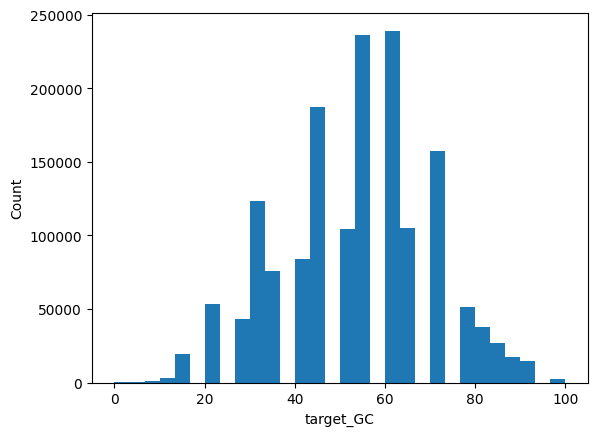

In [11]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

SAMD11
	ENST00000616016.5: 1267 / 3436 probes passed the filter 40 < target_GC <  70.
PRDM16
	ENST00000270722.10: 5142 / 8669 probes passed the filter 40 < target_GC <  70.
TP73
	ENST00000378295.9: 3242 / 5163 probes passed the filter 40 < target_GC <  70.
HES2
	ENST00000377834.8: 2974 / 4233 probes passed the filter 40 < target_GC <  70.
PAX7
	ENST00000420770.7: 4510 / 6184 probes passed the filter 40 < target_GC <  70.
GRHL3
	ENST00000361548.9: 2100 / 2805 probes passed the filter 40 < target_GC <  70.
RUNX3
	ENST00000308873.11: 2478 / 4238 probes passed the filter 40 < target_GC <  70.
LIN28A
	ENST00000326279.11: 2605 / 3946 probes passed the filter 40 < target_GC <  70.
NR0B2
	ENST00000254227.4: 872 / 1136 probes passed the filter 40 < target_GC <  70.
TFAP2E
	ENST00000373235.4: 1236 / 2216 probes passed the filter 40 < target_GC <  70.
POU3F1
	ENST00000373012.5: 995 / 2936 probes passed the filter 40 < target_GC <  70.
HEYL
	ENST00000372852.4: 3271 / 4048 probes passed the filter 

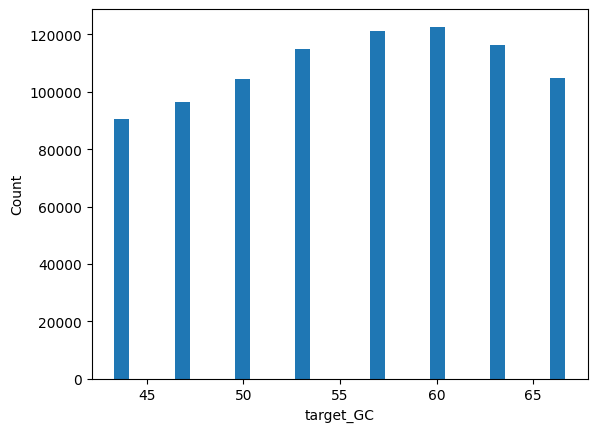

In [12]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

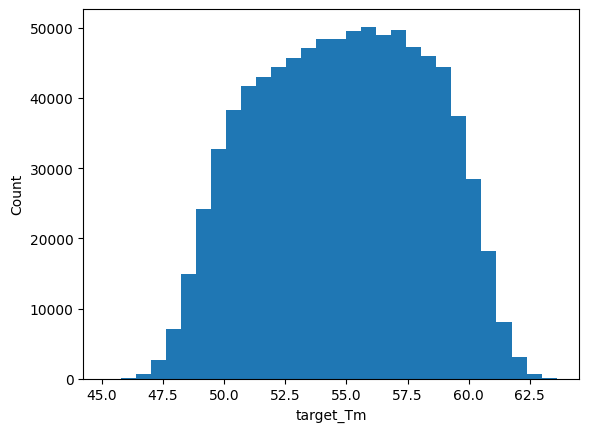

In [13]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, 
                               probe_conc=5,
                               column_key_seq='target_sequence', 
                               column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

SAMD11
	ENST00000616016.5: 1251 / 1267 probes passed the filter 50 < target_Tm <  65.
PRDM16
	ENST00000270722.10: 4909 / 5142 probes passed the filter 50 < target_Tm <  65.
TP73
	ENST00000378295.9: 3126 / 3242 probes passed the filter 50 < target_Tm <  65.
HES2
	ENST00000377834.8: 2795 / 2974 probes passed the filter 50 < target_Tm <  65.
PAX7
	ENST00000420770.7: 4183 / 4510 probes passed the filter 50 < target_Tm <  65.
GRHL3
	ENST00000361548.9: 1938 / 2100 probes passed the filter 50 < target_Tm <  65.
RUNX3
	ENST00000308873.11: 2315 / 2478 probes passed the filter 50 < target_Tm <  65.
LIN28A
	ENST00000326279.11: 2328 / 2605 probes passed the filter 50 < target_Tm <  65.
NR0B2
	ENST00000254227.4: 842 / 872 probes passed the filter 50 < target_Tm <  65.
TFAP2E
	ENST00000373235.4: 1180 / 1236 probes passed the filter 50 < target_Tm <  65.
POU3F1
	ENST00000373012.5: 960 / 995 probes passed the filter 50 < target_Tm <  65.
HEYL
	ENST00000372852.4: 3019 / 3271 probes passed the filter 50

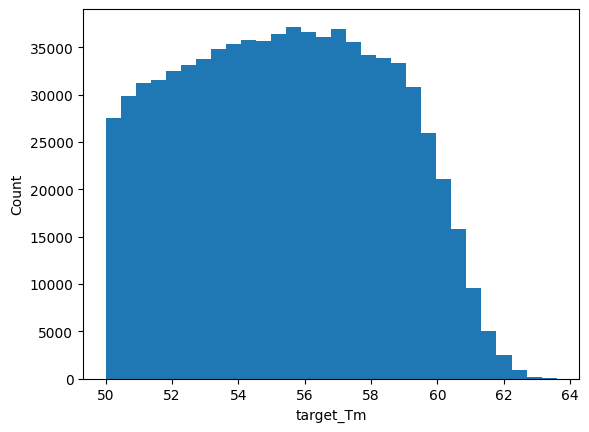

In [14]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', 
                                    lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

Calculate OTs for 0/473 genes.
Calculate OTs for 4/473 genes.
Calculate OTs for 8/473 genes.
Calculate OTs for 12/473 genes.
Calculate OTs for 16/473 genes.
Calculate OTs for 20/473 genes.
Calculate OTs for 24/473 genes.
Calculate OTs for 28/473 genes.
Calculate OTs for 32/473 genes.
Calculate OTs for 36/473 genes.
Calculate OTs for 40/473 genes.
Calculate OTs for 44/473 genes.
Calculate OTs for 48/473 genes.
Calculate OTs for 52/473 genes.
Calculate OTs for 56/473 genes.
Calculate OTs for 60/473 genes.
Calculate OTs for 64/473 genes.
Calculate OTs for 68/473 genes.
Calculate OTs for 72/473 genes.
Calculate OTs for 76/473 genes.
Calculate OTs for 80/473 genes.
Calculate OTs for 84/473 genes.
Calculate OTs for 88/473 genes.
Calculate OTs for 92/473 genes.
Calculate OTs for 96/473 genes.
Calculate OTs for 100/473 genes.
Calculate OTs for 104/473 genes.
Calculate OTs for 108/473 genes.
Calculate OTs for 112/473 genes.
Calculate OTs for 116/473 genes.
Calculate OTs for 120/473 genes.
Calcu

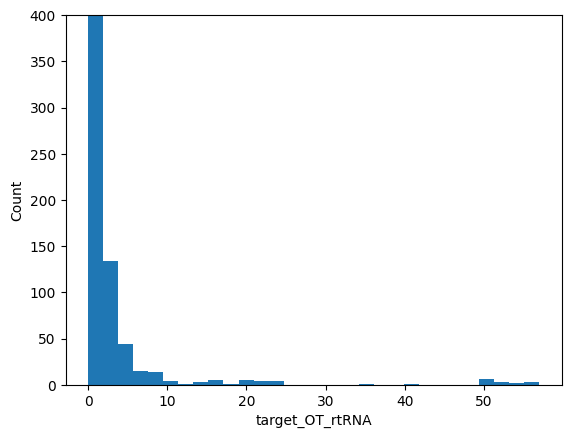

SAMD11
	ENST00000616016.5: 1251 / 1251 probes passed the filter -inf < target_OT_rtRNA <  0.5.
PRDM16
	ENST00000270722.10: 4909 / 4909 probes passed the filter -inf < target_OT_rtRNA <  0.5.
TP73
	ENST00000378295.9: 3126 / 3126 probes passed the filter -inf < target_OT_rtRNA <  0.5.
HES2
	ENST00000377834.8: 2778 / 2795 probes passed the filter -inf < target_OT_rtRNA <  0.5.
PAX7
	ENST00000420770.7: 4183 / 4183 probes passed the filter -inf < target_OT_rtRNA <  0.5.
GRHL3
	ENST00000361548.9: 1938 / 1938 probes passed the filter -inf < target_OT_rtRNA <  0.5.
RUNX3
	ENST00000308873.11: 2315 / 2315 probes passed the filter -inf < target_OT_rtRNA <  0.5.
LIN28A
	ENST00000326279.11: 2328 / 2328 probes passed the filter -inf < target_OT_rtRNA <  0.5.
NR0B2
	ENST00000254227.4: 842 / 842 probes passed the filter -inf < target_OT_rtRNA <  0.5.
TFAP2E
	ENST00000373235.4: 1180 / 1180 probes passed the filter -inf < target_OT_rtRNA <  0.5.
POU3F1
	ENST00000373012.5: 960 / 960 probes passed the fil

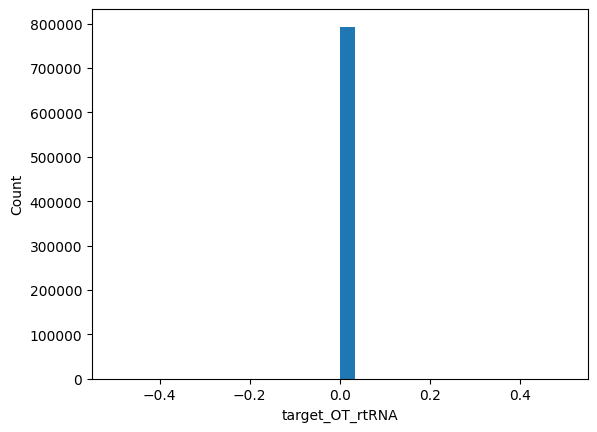

In [15]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
plot.plot_hist(probe_dict, 'target_OT_rtRNA')

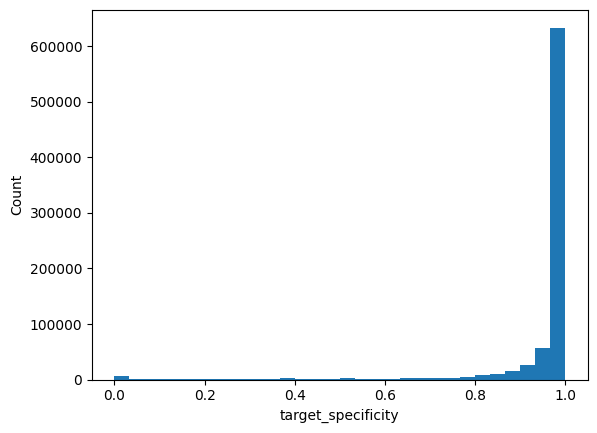

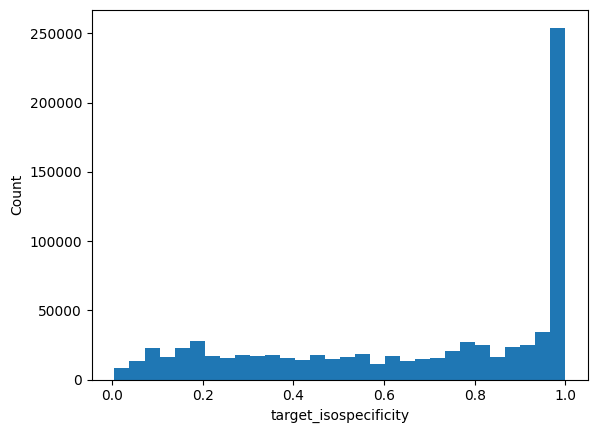

In [16]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

SAMD11
	ENST00000616016.5: 853 / 1251 probes passed the filter 0.999 < target_specificity <  inf.
PRDM16
	ENST00000270722.10: 3411 / 4909 probes passed the filter 0.999 < target_specificity <  inf.
TP73
	ENST00000378295.9: 2047 / 3126 probes passed the filter 0.999 < target_specificity <  inf.
HES2
	ENST00000377834.8: 1508 / 2778 probes passed the filter 0.999 < target_specificity <  inf.
PAX7
	ENST00000420770.7: 2764 / 4183 probes passed the filter 0.999 < target_specificity <  inf.
GRHL3
	ENST00000361548.9: 1542 / 1938 probes passed the filter 0.999 < target_specificity <  inf.
RUNX3
	ENST00000308873.11: 1603 / 2315 probes passed the filter 0.999 < target_specificity <  inf.
LIN28A
	ENST00000326279.11: 1073 / 2328 probes passed the filter 0.999 < target_specificity <  inf.
NR0B2
	ENST00000254227.4: 580 / 842 probes passed the filter 0.999 < target_specificity <  inf.
TFAP2E
	ENST00000373235.4: 760 / 1180 probes passed the filter 0.999 < target_specificity <  inf.
POU3F1
	ENST00000373

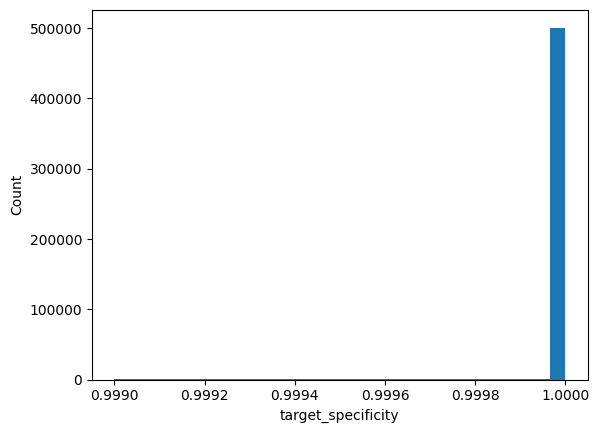

In [17]:
# Filter the specificities of the target regions
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.999)
plot.plot_hist(probe_dict, 'target_specificity')

# Design readout sequences

In [18]:
# load readouts
readouts_df = pd.read_csv(readout_seq_file, index_col=0)
readouts_df.loc[bit_names]

,readout_seq,readout_seq_rc,adaptor_color,adaptor_seq
id,,,,
NDB826,ATATGTCGATGTCCTTAGAC,GTCTAAGGACATCGACATAT,750nm,ATATGTCGATGTCCTTAGACTTTGCACTGCCGTCCTTGACTTTGCA...
NDB755,TGCGACATGTTATGCTAGGC,GCCTAGCATAACATGTCGCA,647nm,TGCGACATGTTATGCTAGGCGATCCGATTGGAACCGTCCCGATCCG...
NDB759,TGACTGTCGTTGACTCTCGG,CCGAGAGTCAACGACAGTCA,565nm,TGACTGTCGTTGACTCTCGGTGCGAACTGTCCGGCTTTCATGCGAA...
NDB376,GACTTTGTGGGTACGTTGAT,ATCAACGTACCCACAAAGTC,750nm,GACTTTGTGGGTACGTTGATTTTGCACTGCCGTCCTTGACTTTGCA...
NDB578,AGGCGATACATGAGAGGCGT,ACGCCTCTCATGTATCGCCT,647nm,AGGCGATACATGAGAGGCGTGATCCGATTGGAACCGTCCCGATCCG...
NDB795,GGGCGTCTGTTACACGTTTG,CAAACGTGTAACAGACGCCC,565nm,GGGCGTCTGTTACACGTTTGTGCGAACTGTCCGGCTTTCATGCGAA...
NDB865,GATCCCGGTCGGATATGTGA,TCACATATCCGACCGGGATC,750nm,GATCCCGGTCGGATATGTGATTTGCACTGCCGTCCTTGACTTTGCA...
NDB713,GGTGGTTGTCACTTTCCGAA,TTCGGAAAGTGACAACCACC,647nm,GGTGGTTGTCACTTTCCGAAGATCCGATTGGAACCGTCCCGATCCG...
NDB777,CGGCGAATTTGCTTTCGTTA,TAACGAAAGCAAATTCGCCG,565nm,CGGCGAATTTGCTTTCGTTATGCGAACTGTCCGGCTTTCATGCGAA...


In [19]:
readout_seqs = pd.DataFrame({
    'id':bit_names, 
    'description':bit_names, 
    'sequence':readouts_df.loc[bit_names, 'readout_seq'].values
})
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)
readout_seqs

,id,description,sequence,on-bit
0,NDB826,NDB826,ATATGTCGATGTCCTTAGAC,0
1,NDB755,NDB755,TGCGACATGTTATGCTAGGC,1
2,NDB759,NDB759,TGACTGTCGTTGACTCTCGG,2
3,NDB376,NDB376,GACTTTGTGGGTACGTTGAT,3
4,NDB578,NDB578,AGGCGATACATGAGAGGCGT,4
5,NDB795,NDB795,GGGCGTCTGTTACACGTTTG,5
6,NDB865,NDB865,GATCCCGGTCGGATATGTGA,6
7,NDB713,NDB713,GGTGGTTGTCACTTTCCGAA,7
8,NDB777,NDB777,CGGCGAATTTGCTTTCGTTA,8
9,NDB817,NDB817,GAACTCGTTGACTAAGCATT,9


In [20]:
# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "A" between the concatenated sequences.
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, N_readout_per_probe=2, 
                                     spacer='A', gene_id_key='name', n_threads=8, each_probe_1_on_bit=False)

Added readout sequences to 853 probes.
Added readout sequences to 615 probes.
Added readout sequences to 687 probes.
Added readout sequences to 901 probes.
Added readout sequences to 1233 probes.
Added readout sequences to 1009 probes.
Added readout sequences to 707 probes.
Added readout sequences to 1815 probes.
Added readout sequences to 1622 probes.
Added readout sequences to 1165 probes.
Added readout sequences to 492 probes.
Added readout sequences to 955 probes.
Added readout sequences to 970 probes.
Added readout sequences to 903 probes.
Added readout sequences to 1434 probes.
Added readout sequences to 559 probes.
Added readout sequences to 728 probes.
Added readout sequences to 859 probes.
Added readout sequences to 2255 probes.
Added readout sequences to 1554 probes.
Added readout sequences to 613 probes.
Added readout sequences to 3411 probes.
Added readout sequences to 650 probes.
Added readout sequences to 364 probes.
Added readout sequences to 511 probes.
Added readout se

# Primer design

In [21]:
# Load the primer candidates into data frames
forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)
forward_primers = forward_primers.set_index('id')
reverse_primers = reverse_primers.set_index('id')
display(forward_primers)
display(reverse_primers)

,description,sequence,sequence_rc
id,,,
W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG
W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG
W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG
W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG
W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA
W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA
W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA
W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC
W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG


,description,sequence,sequence_rc
id,,,
W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA
W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA
W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA
W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA
W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA
W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA
W1B02_primer_13,W1B02_primer_13,TAATACGACTCACTATAGGGCAATTAATCGCCCGGTGCCA,TGGCACCGGGCGATTAATTGCCCTATAGTGAGTCGTATTA
W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA
W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA


In [22]:
# Selet primers
# Make an off-target from the current probe sequences.
ottable_target_readout = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15)

# Calculate the off-targets for the primer sequences and their reverse-complements
# Usually, there shouln't be any off-targets
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)

# Compute the primer off-targets to rRNA/tRNAs and the transcriptome
ot.calc_OTs_df(forward_primers, ottable_rtRNAs, 'sequence', 'sequence_OT_rtRNA', 15)
ot.calc_OTs_df(forward_primers, ottable_rtRNAs, 'sequence_rc', 'sequence_rc_OT_rtRNA', 15)
ot.calc_OTs_df(reverse_primers, ottable_rtRNAs, 'sequence', 'sequence_OT_rtRNA', 15)
ot.calc_OTs_df(reverse_primers, ottable_rtRNAs, 'sequence_rc', 'sequence_rc_OT_rtRNA', 15)

ot.calc_OTs_df(forward_primers, ottable_transcriptome, 'sequence', 'sequence_OT_transcriptome', 17)
ot.calc_OTs_df(forward_primers, ottable_transcriptome, 'sequence_rc', 'sequence_rc_OT_transcriptome', 17)
ot.calc_OTs_df(reverse_primers, ottable_transcriptome, 'sequence', 'sequence_OT_transcriptome', 17)
ot.calc_OTs_df(reverse_primers, ottable_transcriptome, 'sequence_rc', 'sequence_rc_OT_transcriptome', 17)

# Display primer OT tables to manually select
display(forward_primers)
display(reverse_primers)

,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT,sequence_OT_rtRNA,sequence_rc_OT_rtRNA,sequence_OT_transcriptome,sequence_rc_OT_transcriptome
id,,,,,,,,,
W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG,0,0,0,0,0,0
W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0,0,0,0,0
W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0,0,0,0,0
W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0,0,0,0,0
W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA,0,0,0,0,0,0
W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA,0,0,0,0,0,0
W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA,0,0,0,0,0,0
W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC,0,0,0,0,0,0
W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG,0,0,0,0,0,0


,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT,sequence_OT_rtRNA,sequence_rc_OT_rtRNA,sequence_OT_transcriptome,sequence_rc_OT_transcriptome
id,,,,,,,,,
W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA,0,0,0,0,37.59,66.84
W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA,0,0,0,0,0.00,0.00
W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA,0,1,0,0,0.00,0.00
W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA,0,0,0,0,0.00,0.00
W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0,0,0,0.00,0.00
W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0,0,0,0.00,0.00
W1B02_primer_13,W1B02_primer_13,TAATACGACTCACTATAGGGCAATTAATCGCCCGGTGCCA,TGGCACCGGGCGATTAATTGCCCTATAGTGAGTCGTATTA,0,0,0,0,0.00,0.00
W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA,0,1,0,0,0.00,0.00
W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA,0,0,0,0,0.00,0.00


In [23]:
# manually select primers:
selected_forward_primer_name = 'W1A05_primer_4'
selected_reverse_primer_name = 'W1B02_primer_13'

selected_primers = pd.concat([
    forward_primers.loc[forward_primers.index==selected_forward_primer_name],
    reverse_primers.loc[reverse_primers.index==selected_reverse_primer_name]],
    ignore_index=True)
selected_primers.index = [selected_forward_primer_name, selected_reverse_primer_name]

selected_primers.to_csv(selected_primers_file)
selected_primers

,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT,sequence_OT_rtRNA,sequence_rc_OT_rtRNA,sequence_OT_transcriptome,sequence_rc_OT_transcriptome
W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0,0,0,0.0,0.0
W1B02_primer_13,W1B02_primer_13,TAATACGACTCACTATAGGGCAATTAATCGCCCGGTGCCA,TGGCACCGGGCGATTAATTGCCCTATAGTGAGTCGTATTA,0,0,0,0,0.0,0.0


In [24]:
# Add the primer sequences
# NOTE: the sequence after primer addition should be (reverse_primer)-(target_readouts)-(forward_primer_rc)
primer_design.add_primer_sequences(probe_dict, 
                reverse_primers.loc[selected_reverse_primer_name]['sequence'], 
                forward_primers.loc[selected_forward_primer_name]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence')

# Notice that the T7 promoter (the first 17 bases of the reverse primer) will be lost after in vitro transcription
# create a column of the T7 transcribed sequences for the subsequent quality check
primer_design.add_primer_sequences(probe_dict, 
                reverse_primers.loc[selected_reverse_primer_name]['sequence'][17:], 
                forward_primers.loc[selected_forward_primer_name]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence_t7_transcribed')

Calculate OTs for 0/473 genes.
Calculate OTs for 4/473 genes.
Calculate OTs for 8/473 genes.
Calculate OTs for 12/473 genes.
Calculate OTs for 16/473 genes.
Calculate OTs for 20/473 genes.
Calculate OTs for 24/473 genes.
Calculate OTs for 28/473 genes.
Calculate OTs for 32/473 genes.
Calculate OTs for 36/473 genes.
Calculate OTs for 40/473 genes.
Calculate OTs for 44/473 genes.
Calculate OTs for 48/473 genes.
Calculate OTs for 52/473 genes.
Calculate OTs for 56/473 genes.
Calculate OTs for 60/473 genes.
Calculate OTs for 64/473 genes.
Calculate OTs for 68/473 genes.
Calculate OTs for 72/473 genes.
Calculate OTs for 76/473 genes.
Calculate OTs for 80/473 genes.
Calculate OTs for 84/473 genes.
Calculate OTs for 88/473 genes.
Calculate OTs for 92/473 genes.
Calculate OTs for 96/473 genes.
Calculate OTs for 100/473 genes.
Calculate OTs for 104/473 genes.
Calculate OTs for 108/473 genes.
Calculate OTs for 112/473 genes.
Calculate OTs for 116/473 genes.
Calculate OTs for 120/473 genes.
Calcu

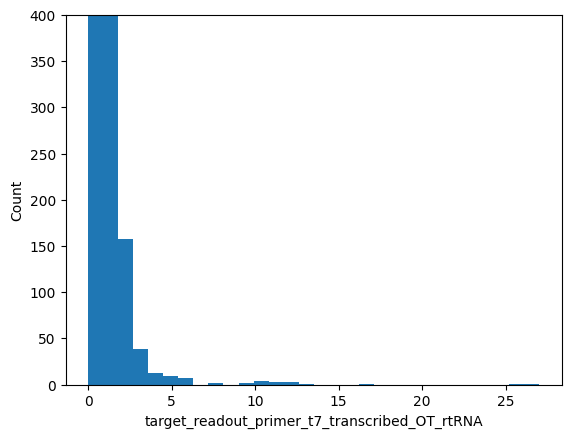

SAMD11
	ENST00000616016.5: 853 / 853 probes passed the filter -inf < target_readout_primer_t7_transcribed_OT_rtRNA <  0.5.
PRDM16
	ENST00000270722.10: 3410 / 3411 probes passed the filter -inf < target_readout_primer_t7_transcribed_OT_rtRNA <  0.5.
TP73
	ENST00000378295.9: 2034 / 2047 probes passed the filter -inf < target_readout_primer_t7_transcribed_OT_rtRNA <  0.5.
HES2
	ENST00000377834.8: 1503 / 1508 probes passed the filter -inf < target_readout_primer_t7_transcribed_OT_rtRNA <  0.5.
PAX7
	ENST00000420770.7: 2764 / 2764 probes passed the filter -inf < target_readout_primer_t7_transcribed_OT_rtRNA <  0.5.
GRHL3
	ENST00000361548.9: 1542 / 1542 probes passed the filter -inf < target_readout_primer_t7_transcribed_OT_rtRNA <  0.5.
RUNX3
	ENST00000308873.11: 1603 / 1603 probes passed the filter -inf < target_readout_primer_t7_transcribed_OT_rtRNA <  0.5.
LIN28A
	ENST00000326279.11: 1073 / 1073 probes passed the filter -inf < target_readout_primer_t7_transcribed_OT_rtRNA <  0.5.
NR0B2
	

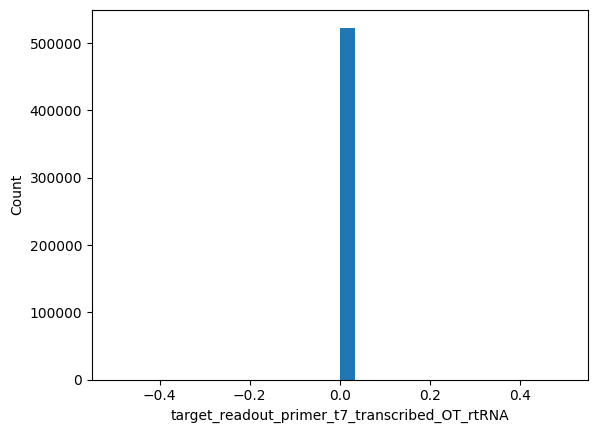

In [25]:
# Filter out probes that have off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_readout_primer_sequence_t7_transcribed', 'target_readout_primer_t7_transcribed_OT_rtRNA', 15)
plot.plot_hist(probe_dict, 'target_readout_primer_t7_transcribed_OT_rtRNA', y_max=400)
filters.filter_probe_dict_by_metric(probe_dict, 'target_readout_primer_t7_transcribed_OT_rtRNA', upper_bound=0.5)
plot.plot_hist(probe_dict, 'target_readout_primer_t7_transcribed_OT_rtRNA')

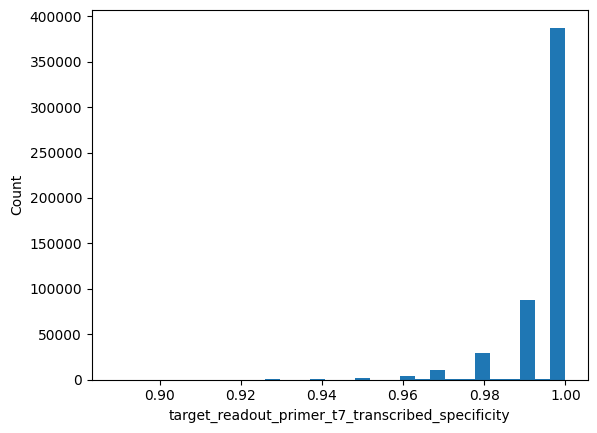

In [26]:
# Calculate the specificities and isoform specificities of the full probe sequences
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_readout_primer_sequence_t7_transcribed', 'target_readout_primer_t7_transcribed_specificity', 'target_readout_primer_t7_transcribed_isospecificity', 17)
plot.plot_hist(probe_dict, 'target_readout_primer_t7_transcribed_specificity')

SAMD11
	ENST00000616016.5: 628 / 853 probes passed the filter 0.999 < target_readout_primer_t7_transcribed_specificity <  inf.
PRDM16
	ENST00000270722.10: 1913 / 3410 probes passed the filter 0.999 < target_readout_primer_t7_transcribed_specificity <  inf.
TP73
	ENST00000378295.9: 1518 / 2034 probes passed the filter 0.999 < target_readout_primer_t7_transcribed_specificity <  inf.
HES2
	ENST00000377834.8: 1082 / 1503 probes passed the filter 0.999 < target_readout_primer_t7_transcribed_specificity <  inf.
PAX7
	ENST00000420770.7: 2188 / 2764 probes passed the filter 0.999 < target_readout_primer_t7_transcribed_specificity <  inf.
GRHL3
	ENST00000361548.9: 1185 / 1542 probes passed the filter 0.999 < target_readout_primer_t7_transcribed_specificity <  inf.
RUNX3
	ENST00000308873.11: 1225 / 1603 probes passed the filter 0.999 < target_readout_primer_t7_transcribed_specificity <  inf.
LIN28A
	ENST00000326279.11: 783 / 1073 probes passed the filter 0.999 < target_readout_primer_t7_transcri

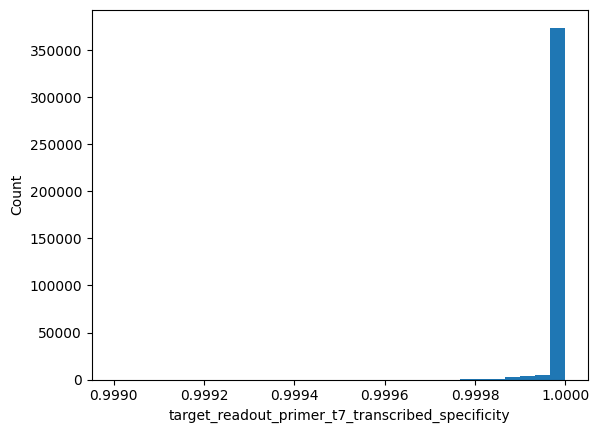

In [27]:
# Filter the specificities of the target regions plus readouts
filters.filter_probe_dict_by_metric(probe_dict, 'target_readout_primer_t7_transcribed_specificity', lower_bound=0.999)
plot.plot_hist(probe_dict, 'target_readout_primer_t7_transcribed_specificity')

,gene,transcript,n_probes,n_max_no_overlap_probes
48,VAX2,ENST00000234392.3,273,21
284,NANOG,ENST00000229307.9,135,21
344,BATF,ENST00000286639.8,265,23
257,DBX1,ENST00000524983.3,344,23
346,GSC,ENST00000238558.5,331,24
...,...,...,...,...
219,AKNA,ENST00000374088.8,1913,172
449,ZNF831,ENST00000371030.4,2702,193
467,AR,ENST00000374690.9,2182,195
216,PAX5,ENST00000358127.9,2848,200


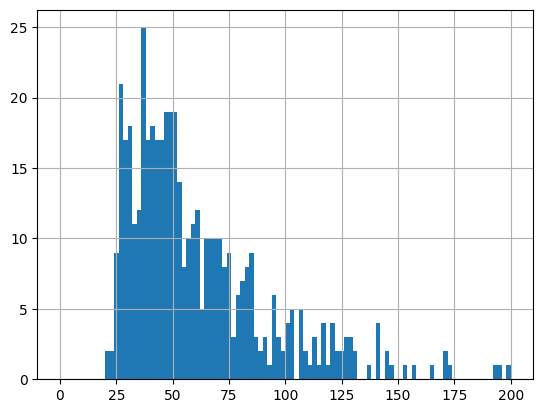

In [28]:
# Count the max number of non-overlapping probes
max_non_overlapping_probes_count_df = ps.count_max_non_overlapping_probes(probe_dict)
max_non_overlapping_probes_count_df['n_max_no_overlap_probes'].hist(bins=100, range=(0, 200))
max_non_overlapping_probes_count_df.sort_values('n_max_no_overlap_probes')

# Select probes

In [29]:
%%time
# Select probes by a stochastic greedy algorithms that optimizes the on-bit coverage
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=72, N_on_bits=4, N_threads=16)

VAX2:ENST00000234392.3: selected 72/273 probes with N_overlapping_bases=2175.0 and on-bit_coverage={10: 37, 2: 36, 7: 35, 15: 36}.
FOXD2:ENST00000334793.6: selected 72/292 probes with N_overlapping_bases=983.0 and on-bit_coverage={8: 38, 26: 34, 5: 34, 23: 38}.
ALX3:ENST00000647563.2: selected 72/416 probes with N_overlapping_bases=694.0 and on-bit_coverage={9: 36, 2: 36, 5: 36, 14: 36}.
NR0B2:ENST00000254227.4: selected 72/445 probes with N_overlapping_bases=1341.0 and on-bit_coverage={24: 38, 0: 36, 20: 36, 12: 34}.
ZFP42:ENST00000326866.5: selected 72/438 probes with N_overlapping_bases=859.0 and on-bit_coverage={25: 36, 18: 36, 13: 36, 6: 36}.
MAEL:ENST00000367872.9: selected 72/447 probes with N_overlapping_bases=970.0 and on-bit_coverage={17: 36, 18: 36, 21: 36, 22: 36}.
OTP:ENST00000306422.5: selected 72/579 probes with N_overlapping_bases=520.0 and on-bit_coverage={0: 35, 3: 37, 4: 35, 7: 37}.
NEUROD1:ENST00000295108.4: selected 72/622 probes with N_overlapping_bases=924.0 and 

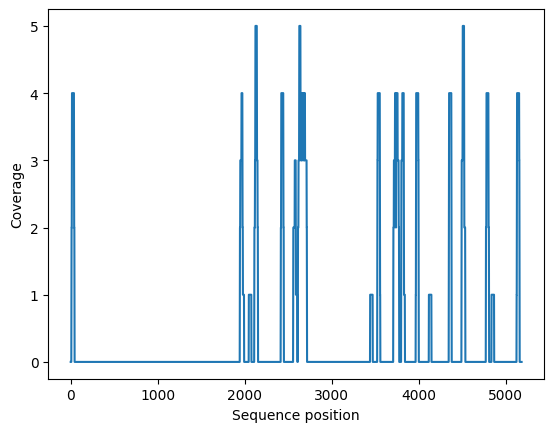

In [30]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'ENST00000229307.9'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['NANOG']['ENST00000229307.9'], seq_len)

# Quality check

Calculate OTs for 0/473 genes.
Calculate OTs for 4/473 genes.
Calculate OTs for 8/473 genes.
Calculate OTs for 12/473 genes.
Calculate OTs for 16/473 genes.
Calculate OTs for 20/473 genes.
Calculate OTs for 24/473 genes.
Calculate OTs for 28/473 genes.
Calculate OTs for 32/473 genes.
Calculate OTs for 36/473 genes.
Calculate OTs for 40/473 genes.
Calculate OTs for 44/473 genes.
Calculate OTs for 48/473 genes.
Calculate OTs for 52/473 genes.
Calculate OTs for 56/473 genes.
Calculate OTs for 60/473 genes.
Calculate OTs for 64/473 genes.
Calculate OTs for 68/473 genes.
Calculate OTs for 72/473 genes.
Calculate OTs for 76/473 genes.
Calculate OTs for 80/473 genes.
Calculate OTs for 84/473 genes.
Calculate OTs for 88/473 genes.
Calculate OTs for 92/473 genes.
Calculate OTs for 96/473 genes.
Calculate OTs for 100/473 genes.
Calculate OTs for 104/473 genes.
Calculate OTs for 108/473 genes.
Calculate OTs for 112/473 genes.
Calculate OTs for 116/473 genes.
Calculate OTs for 120/473 genes.
Calcu

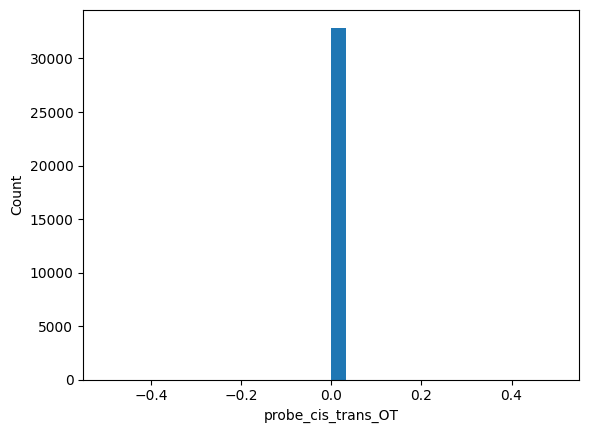

CPU times: user 49.6 s, sys: 685 ms, total: 50.2 s
Wall time: 50.2 s


In [31]:
%%time
# Filter out the probes that self complement or complement with other probes.

# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_primer_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_primer_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have large numbers of cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')

# Save the designed probes

In [32]:
# Also get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(probe_dict, 'target_readout_primer_sequence_t7_transcribed', 'target_readout_primer_sequence_t7_transcribed_rc')
# Write the designed probes
all_probes_df = p_d.probe_dict_to_df(probe_dict)
all_probes_df.to_csv(probe_output_file, index=False)

,gene_id,gene_short_name,transcript_id,FPKM,length,barcode,N_probes,probe_bit_coverage,max_N_non_overlapping_probes
48,ENSG00000116035.4,VAX2,ENST00000234392.3,38.52,1161,001000010010000100000000000,70,36:33:36:35,20
284,ENSG00000111704.12,NANOG,ENST00000229307.9,0.29,5182,000000000000001100110000000,71,38:39:29:36,21
257,ENSG00000109851.7,DBX1,ENST00000524983.3,0.87,1242,000000010000010000100000100,71,38:36:36:32,22
346,ENSG00000133937.5,GSC,ENST00000238558.5,58.19,1140,010100000000000000001010000,68,31:34:34:37,23
344,ENSG00000156127.8,BATF,ENST00000286639.8,232.53,913,100000000100000010000000010,71,36:35:36:35,23
...,...,...,...,...,...,...,...,...,...
98,ENSG00000073282.14,TP63,ENST00000264731.8,30.44,4944,010000100000000000011000000,72,37:37:35:35,72
444,ENSG00000101076.21,HNF4A,ENST00000316673.9,57.19,4645,001000100000000000100010000,72,36:36:36:36,72
43,ENSG00000075426.13,FOSL2,ENST00000264716.9,379.01,6713,000001001000000000001000010,72,36:36:36:36,72
426,ENSG00000105392.17,CRX,ENST00000221996.12,5.41,4366,110000000000000000000000110,72,35:37:37:35,72


<Axes: >

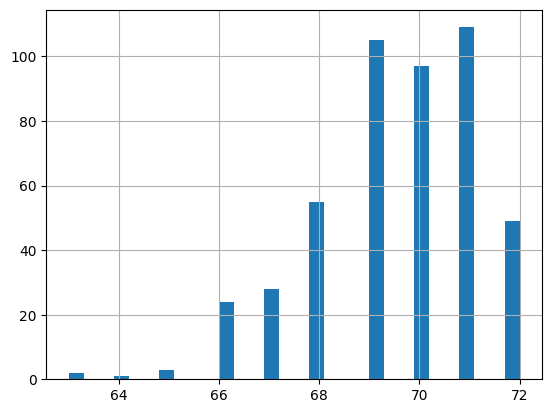

In [33]:
# Write the transcript level report
transcript_level_report = qc.generate_transcript_level_report(probe_dict, transcriptome)
display(transcript_level_report.sort_values('max_N_non_overlapping_probes'))
transcript_level_report.to_csv(transcript_level_report_file, index=False)
transcript_level_report['N_probes'].hist(bins=30)

In [34]:
# Make a column of probe names
probe_names = np.array(all_probes_df['gene_id']) + '_' + np.array(all_probes_df['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(all_probes_df['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(all_probes_df['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(all_probes_df['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(all_probes_df['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(all_probes_df['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(all_probes_df['readout_names'])
all_probes_df['probe_names'] = probe_names


twist_final_probes = pd.DataFrame(
    {
        "name": all_probes_df['probe_names'].values,
        "sequence": all_probes_df['target_readout_primer_sequence_t7_transcribed_rc'].values,
    }
)
print(f"saving twist probes to file: {twist_probe_filename}")
twist_final_probes.to_csv(twist_probe_filename, index=None)

saving twist probes to file: temporary_data/design_outputs/twist_probes.csv
